# Utilización, procesamiento y visualización de grandes volúmenes de datos

Los algoritmos de Machine Learning están altamente relacionados con Bid Data, debido a que un entrenamiento de Machine Learning requiere grandes cantidades de datos. Herramientas como PySpark facilitan el tratamiento de estos datos, y son ampliamente usados en la industria. En este proyecto se utiliza PySpark y su librería ML para resolver un problema de clasificación. El Dataset proviene de Kaggle, y consiste en un archivo de con información de diferentes paquetes de datos enviados hacia distintos servidores. Los paquetes están clasificados como DDoS o tráfico benigno (común). Además, se utiliza Tableau como herramienta de visualización.
 [Dataset](https://www.kaggle.com/datasets/devendra416/ddos-datasets/data).

## Reducción del dataset

El dataset original contiene alrededor de 6 GB. El dataset utilizado es un subset de 1.1 GB. Esta reducción se realizó por limitaciones en el hardware, que no permitía trabajar con un dataset tan grande. El siguiente código se utilizó en un entorno local para tomar una muestra del dataset.


```
import pandas as pd

# File paths
input_file = "/home/oskar/Documents/ITC/IA/BigData/ddos_balanced/final_dataset.csv"
output_file = (
    "/home/oskar/Documents/ITC/IA/BigData/ddos_balanced/final_reduced_dataset.csv"
)

# Chunk size
chunk_size = 10000  # Adjust this based on your memory capacity

# List to hold sampled data
sampled_chunks = []

# Read the CSV file in chunks
for chunk in pd.read_csv(input_file, chunksize=chunk_size):
    # Sample approximately 1/6 of the rows from each chunk
    sampled_chunk = chunk.sample(frac=1 / 6, random_state=42)
    sampled_chunks.append(sampled_chunk)

# Concatenate all sampled chunks
df_sampled = pd.concat(sampled_chunks)

# Save the sampled rows to a new CSV file
df_sampled.to_csv(output_file, index=False)

print(f"Reduced dataset saved to {output_file}")
```



## Cargar PySpark

PySpark está hecho para poder realizar procesamiento distribuido. Sin embargo, para este proyecto solo se cuenta con un equipo, por lo que se realizará todo el procesamiento en una instancia. Para utilizar procesamiento distribuido, es necesario conectar más instancias a la sesión de PySpark.

Para iniciar, se hacen las instalaciones necesarias para PySpark

In [ ]:
#Bibliotecas para poder trabajar con Spark
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.3//spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz
#Configuración de Spark con Python
!pip install -q findspark
!pip install pyspark

#Estableciendo variable de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

#Buscando e inicializando la instalación de Spark
import findspark
findspark.init()
findspark.find()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,071 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,428 kB]

'/content/spark-3.5.3-bin-hadoop3'

Posteriormente se realizan todos los imports.

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col, rand

Se inicia una sesión de PySpark.

In [ ]:
spark_session = SparkSession.builder.config("spark.driver.memory", "10g").appName('PySpark_ML').getOrCreate()
spark_session

## Cargado de datos

Se conecta Google Drive para extraer el dataset.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se lee el dataset en CSV en un Dataframe de PySpark.

In [ ]:
file_path = '/content/drive/MyDrive/IA avanzada/BigData/final_reduced_dataset.csv'

df_spark = spark_session.read.csv(file_path, header=True, inferSchema=True)
df_spark

DataFrame[Unnamed: 0: int, Flow ID: string, Src IP: string, Src Port: int, Dst IP: string, Dst Port: int, Protocol: int, Timestamp: string, Flow Duration: int, Tot Fwd Pkts: int, Tot Bwd Pkts: int, TotLen Fwd Pkts: double, TotLen Bwd Pkts: double, Fwd Pkt Len Max: double, Fwd Pkt Len Min: double, Fwd Pkt Len Mean: double, Fwd Pkt Len Std: double, Bwd Pkt Len Max: double, Bwd Pkt Len Min: double, Bwd Pkt Len Mean: double, Bwd Pkt Len Std: double, Flow Byts/s: string, Flow Pkts/s: string, Flow IAT Mean: double, Flow IAT Std: double, Flow IAT Max: double, Flow IAT Min: double, Fwd IAT Tot: double, Fwd IAT Mean: double, Fwd IAT Std: double, Fwd IAT Max: double, Fwd IAT Min: double, Bwd IAT Tot: double, Bwd IAT Mean: double, Bwd IAT Std: double, Bwd IAT Max: double, Bwd IAT Min: double, Fwd PSH Flags: int, Bwd PSH Flags: int, Fwd URG Flags: int, Bwd URG Flags: int, Fwd Header Len: int, Bwd Header Len: int, Fwd Pkts/s: double, Bwd Pkts/s: double, Pkt Len Min: double, Pkt Len Max: double, Pkt

Se imprime el Dataframe para verificar que se haya descargado correctamente.

In [ ]:
df_spark.show()

+----------+--------------------+--------------+--------+---------------+--------+--------+--------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------------+-----------+-----------------+------------------+-----------+-----------+-----------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------------+------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+---------------

Se imprime el esquema para revisar el tipo de dato de cada columna.

In [ ]:
df_spark.printSchema()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- Flow ID: string (nullable = true)
 |-- Src IP: string (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst IP: string (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: string (nullable = true)
 |-- Flow Pkts/s: stri

Se realiza un análisis de distribución de las clases a predecir. Se puede observar que las clases están balanceadas, lo cual permite un correcto entrenamiento.

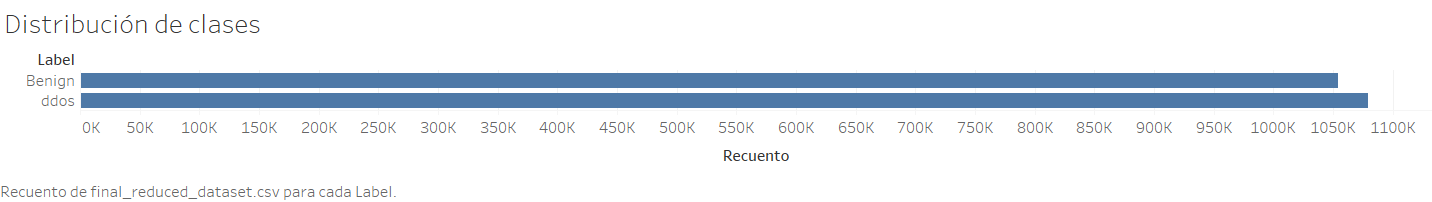

Para el entrenamiento, todas las columnas deben ser de tipo numérico, por lo que se deben explorar las columnas de texto para decidir qué se hará con ellas.

Tanto la columna Dst IP como Src IP, correspondientes a destination y source IP, contienen una distribución muy amplia de valores. Esto se debe a que el tráfico se midió en diferentes fuentes y destinos. Lo más conveniente es eliminar estas columnas, porque crear un one hot encoding sería muy demandante y no proporcionaría información relevante.

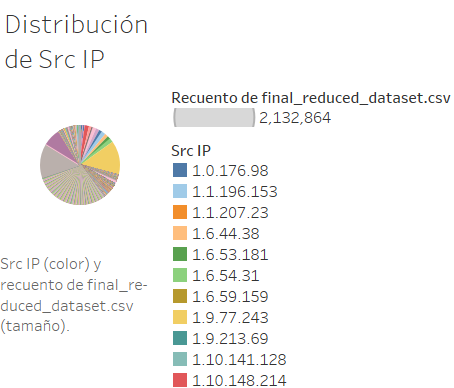

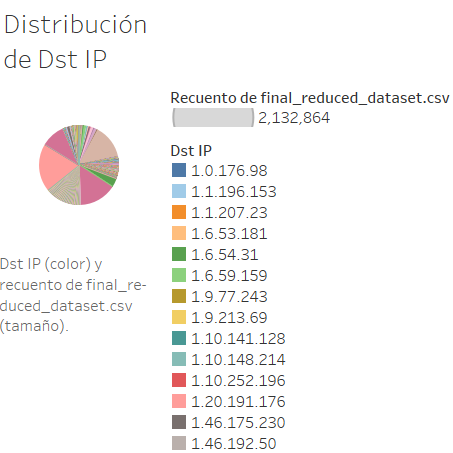

La columna Flow ID es un identificador único que también puede eliminarse, y Timestamp también se eliminará porque no se busca hacer un análisis de tiempo.

Se eliminan las columnas no deseadas.

In [ ]:
df_spark = df_spark.drop("Flow ID", "Src IP", "Dst IP", "Timestamp")
df_spark.show()

+----------+--------+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------------+-----------+-----------------+------------------+-----------+-----------+-----------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------------+------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+-------

Se convierten las columnas con formato incorrecto.

In [ ]:
df_spark = df_spark.withColumn("Flow Byts/s", df_spark["Flow Byts/s"].cast(FloatType()))
df_spark = df_spark.withColumn("Flow Pkts/s", df_spark["Flow Pkts/s"].cast(FloatType()))

# Fill NaN values resulting from conversion errors with 0
df_spark = df_spark.na.fill(0, ["Flow Byts/s", "Flow Pkts/s"])


df_spark.printSchema()
df_spark.show()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: float (nullable = false)
 |-- Flow Pkts/s: float (nullable = false)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: double (nullable = true)
 |

Ahora se deben verificar las columnas numéricas.

Como se puede observar, todas las columnas tienen distribuciones muy sesgadas con outliers. Algunos de estos outliers corresponden a valores inf, los cuales se eliminarán más adelante. La distribución desigual de los valores no se corregirá en este punto, pero se tendrá en cuenta en caso de que el modelo requiera ajustes después del entrenamiento.

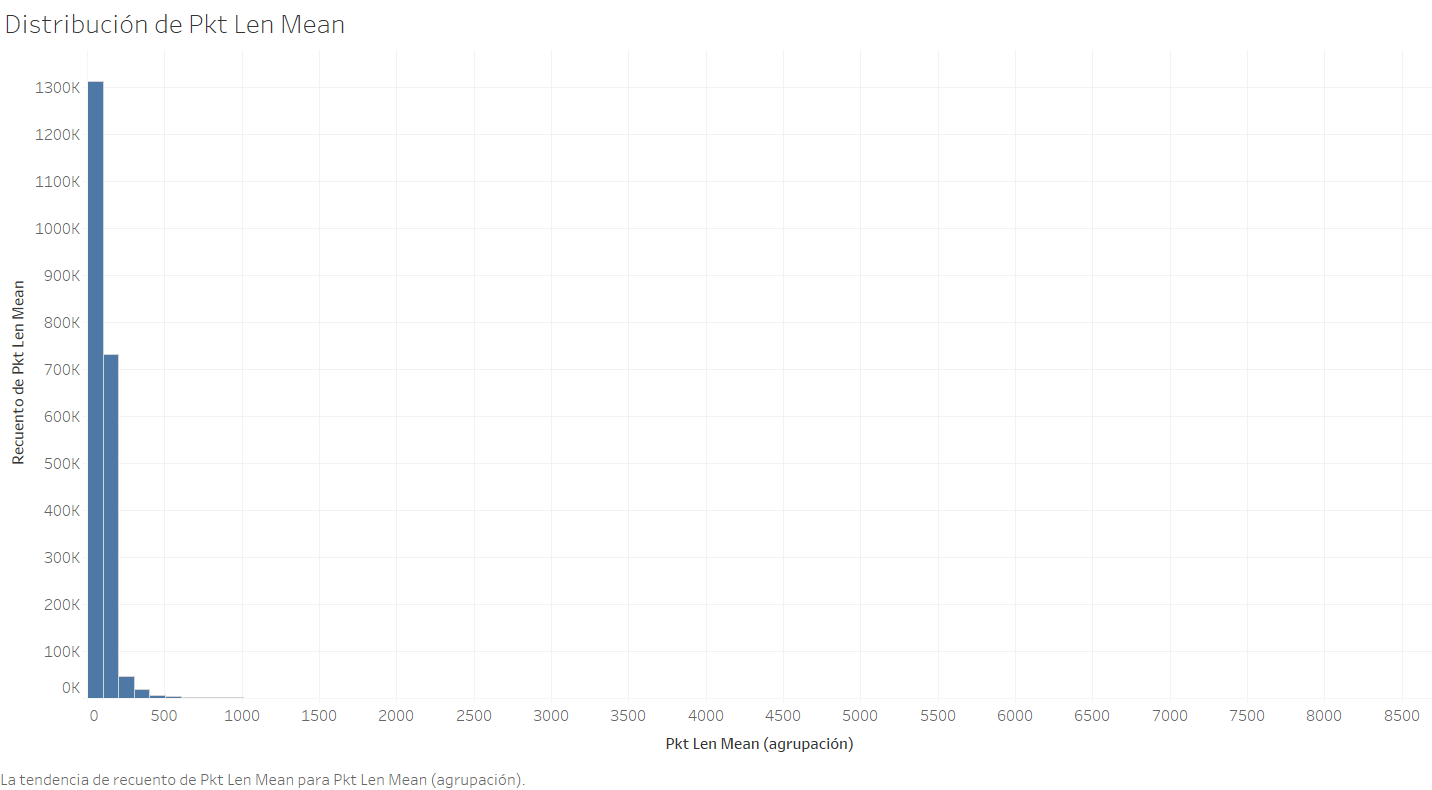

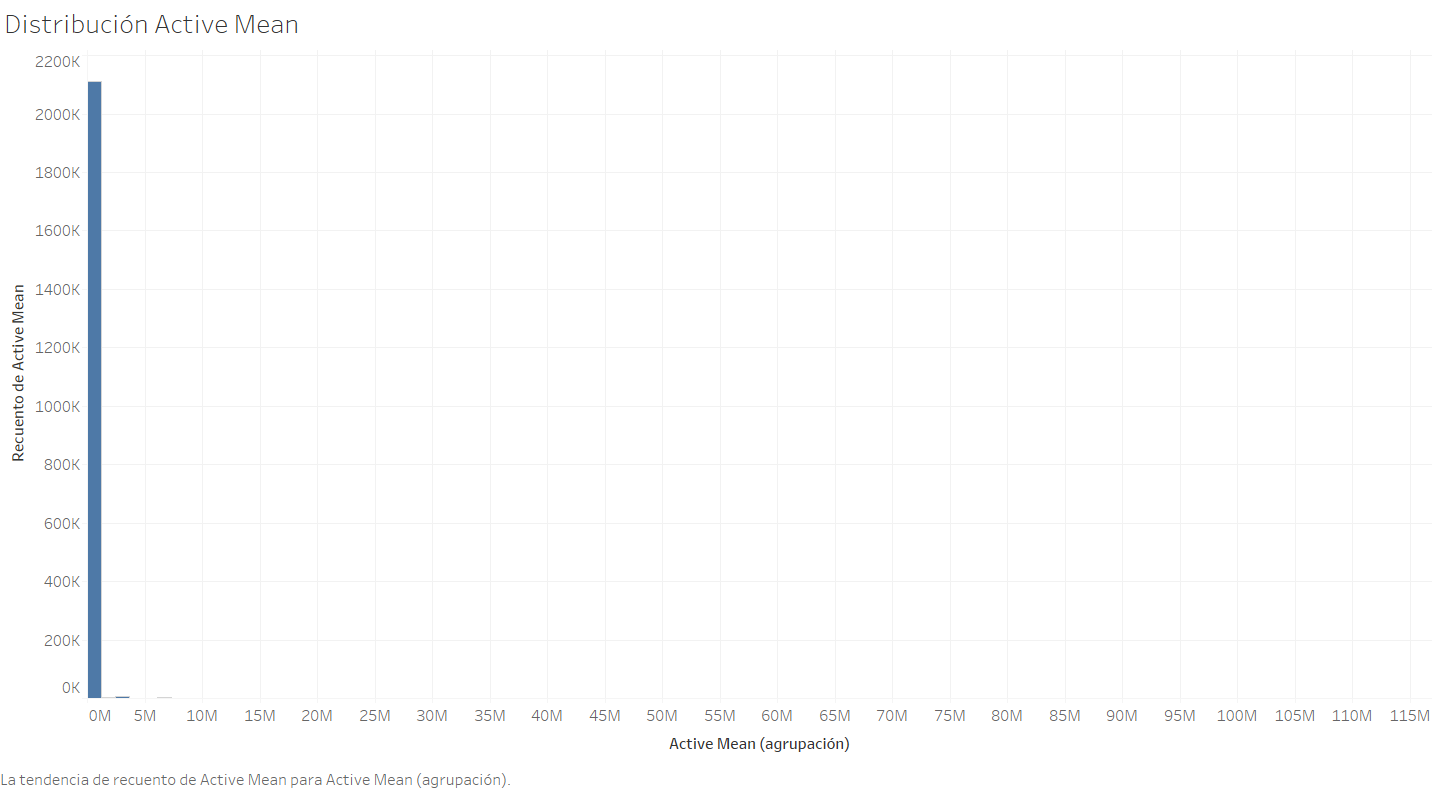

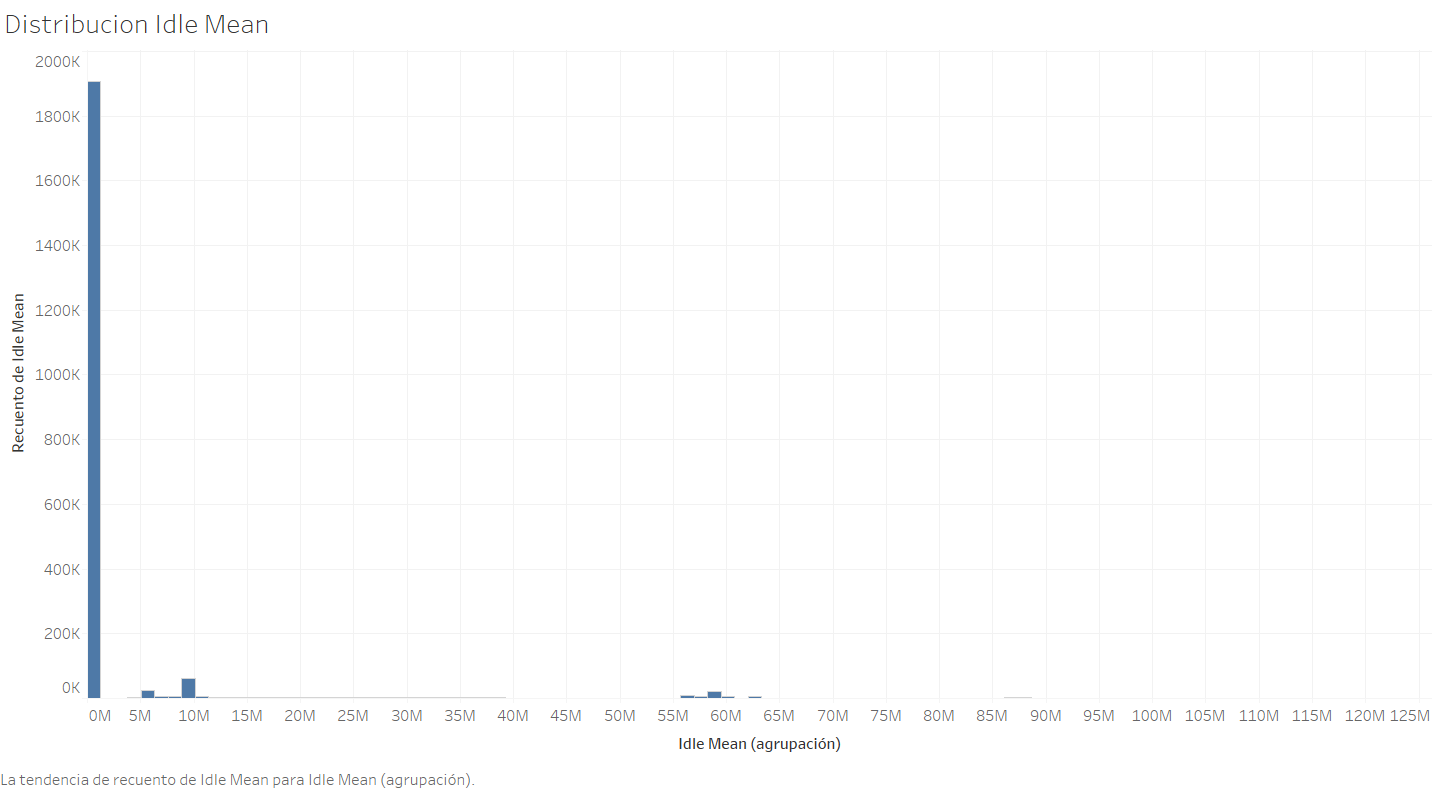

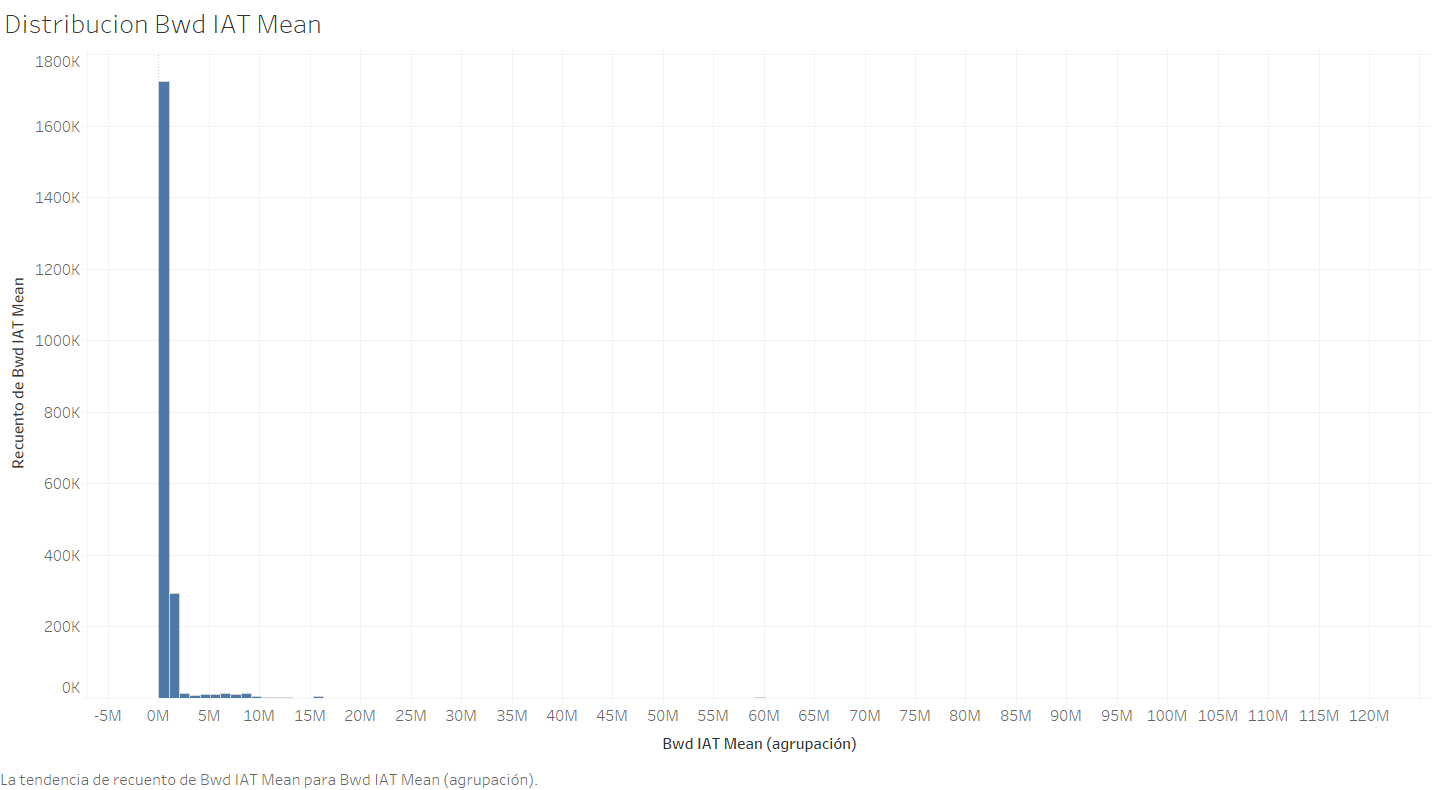

Se eliminan las casillas con valores infinitos, cambiandolas por valores nulos.

In [ ]:
df_spark = df_spark.replace([float('inf'), float('-inf')], None)

Se eliminan todas las filas con valores nulos.

In [ ]:
df_spark = df_spark.dropna()
df_spark.show()

+----------+--------+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+-----------+-----------+------------------+------------------+------------+------------+-----------+-----------------+------------------+-----------+-----------+-----------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------------+------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----

## Análisis de los datos

## Transformaciones


Se utiliza un Pipeline para ensamblar el vector de features y realizar el OneHotEncoding de la columna que contiene los labels.

In [ ]:
# features columns
features = [col for col in df_spark.columns if col != 'Label']

# Label Encoding for 'Label' column
label_indexer = StringIndexer(inputCol="Label", outputCol="label_indexed")

In [ ]:
# Assembling
assembler_inputs = features
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

In [ ]:
# Creating pipeline
pipeline = Pipeline(stages=[label_indexer, assembler])

# Fitting the pipeline and transforming the dataset
df_assembled = pipeline.fit(df_spark).transform(df_spark)

# Show the original labels and their one-hot encodings
df_assembled.select("Label", "label_indexed").distinct().show(truncate=False)

+------+-------------+
|Label |label_indexed|
+------+-------------+
|ddos  |0.0          |
|Benign|1.0          |
+------+-------------+



Ahora se tiene una nueva columna, en la que el label está representado numéricamente:


*   0: Tráfico correspondiente a un ataque DDoS
*   1: Tráfico común



Se elimina la columna de los labels originales.

In [ ]:
# Dropping the original 'Label' column
df_final = df_assembled.drop("Label")

df_final.show()
df_final.printSchema()

+----------+--------+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+-----------+-----------+------------------+------------------+------------+------------+-----------+-----------------+------------------+-----------+-----------+-----------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------------+------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----

Ahora todas las columnas son numéricas, por lo que se puede proceder al modelo.

## Modelo

Se separa el dataset en entrenamiento y pruebas, utilizando una separación aleatoria de 70:30

In [ ]:
train_data, test_data = df_final.randomSplit([0.7, 0.3], seed=42)

Se define un modelo de Random Forest. Este modelo es adecuado para problemas de clasificación, y normalmente es más rápido su entrenamiento, lo cual es una ventaja para el volumen de datos del dataset.

In [ ]:
rf_classifier = RandomForestClassifier(labelCol='label_indexed', featuresCol='features', numTrees=100)
rf_model = rf_classifier.fit(train_data)

Una vez que se tiene entrenado el modelo, se realizan predicciones con el dataset de pruebas.

In [ ]:
predictions = rf_model.transform(test_data)

Se utilizan las herramientas de PySpark para evaluar el modelo, utilizando las predicciones anteriores.

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='label_indexed', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9930229383065168


PAra un modelo de clasificación, la métrica de accuracy es una de las más adecuadas. El valor obtenido nos indica que el modelo predice correctamente en el 99% de los casos.

In [ ]:
predictions.select('label_indexed', 'prediction', 'probability').orderBy(rand()).show(10)

+-------------+----------+--------------------+
|label_indexed|prediction|         probability|
+-------------+----------+--------------------+
|          0.0|       0.0|[0.96500531665957...|
|          0.0|       0.0|[0.96500531665957...|
|          0.0|       0.0|[0.98188575523385...|
|          0.0|       0.0|[0.84709124314797...|
|          0.0|       0.0|[0.96500531665957...|
|          0.0|       0.0|[0.92989366915106...|
|          0.0|       0.0|[0.96453968046639...|
|          1.0|       1.0|[0.00497156378591...|
|          0.0|       0.0|[0.76922070532305...|
|          0.0|       0.0|[0.96447097369521...|
+-------------+----------+--------------------+
only showing top 10 rows



Para realizar una visualización más profunda de los resultados, se utiliza una matriz de confusión, que nos indica en cuantas ocasiones se obtuvo cada resultado.

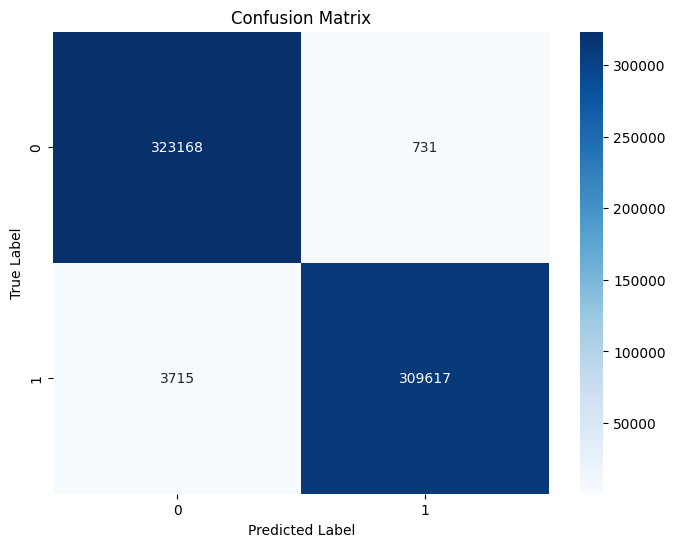

In [ ]:
# Collect label and prediction columns to Pandas for confusion matrix
preds_and_labels = predictions.select('label_indexed', 'prediction').toPandas()
conf_matrix = confusion_matrix(preds_and_labels['label_indexed'], preds_and_labels['prediction'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Se puede observar que el modelo realiza predicciones correctas en la mayoría de los casos. El error más común que realiza el modelo es clasificar tráfico de común (1) como tráfico DDoS (0). Sin embargo, este error ocurre en menos del 0.01% de las ocasiones.